### PyElastica Visualization

In [27]:
import numpy as np

pye_cantilever = np.load("cantilever.npz")
pye_helix_1e7 = np.load("helix_1e7.npz")
pye_helix_1e9 = np.load("helix_1e9.npz")
pye_helix_1e7_damp = np.load("helix_1e7_dampened.npz")
pye_helix_1e9_damp = np.load("helix_1e9_dampened.npz")
pye_snake = np.load("snake.npz")

# All npzs have keys 't' and 'p'
print(pye_cantilever)

NpzFile 'cantilever.npz' with keys: t, p


### Snake Example

In [ ]:
import dismech

def get_snake():
    geom = dismech.GeomParams(rod_r0=0.35*0.005,
                              shell_h=0)

    material = dismech.Material(density=1000,
                                youngs_rod=1e6,
                                youngs_shell=0,
                                poisson_rod=0.5,
                                poisson_shell=0)

    static_2d_sim = dismech.SimParams(static_sim=False,
                                      two_d_sim=False,   # no twisting
                                      use_mid_edge=False,
                                      use_line_search=False,
                                      show_floor=False,
                                      log_data=True,
                                      log_step=1,
                                      dt=1e-2,
                                      max_iter=25,
                                      total_time=10.0,
                                      plot_step=1,
                                      tol=1e-4,
                                      ftol=1e-4,
                                      dtol=1e-2)

    env = dismech.Environment()
    env.add_force('rft', ct=0.5, cn=1.0)

    geo = dismech.Geometry.from_txt(
        '../tests/resources/rod_cantilever/horizontal_rod_n101.txt')

    return dismech.SoftRobot(geom, material, geo, static_2d_sim, env)


def actuate_snake(robot, t,
                  amplitude=0.0393,
                  frequency=0.5,
                  spatial_wavelength=0.3,
                  phase_offset=-np.pi/2,
                  ramp_time=2.0,
                  direction=+1):
    """
    Apply traveling-wave bending strains to the snake robot.

    Parameters
    ----------
    robot : Robot instance (mutated in-place)
    t : float, current sim time [s]
    amplitude : float, peak strain magnitude
    frequency : float, drive frequency [Hz]
    spatial_wavelength : float, body-normalized wavelength (s in [0,1])
    phase_offset : float, phase shift between channels (if both used)
    ramp_time : float, duration over which actuation smoothly ramps from 0->1
    direction : +1 for forward (reversed from your previous, backward drift),
                -1 for backward (original behavior)
    """
    n_bends = robot.bend_springs.inc_strain.shape[0]
    s = np.linspace(0.0, 1.0, n_bends)

    omega = 2.0 * np.pi * frequency
    k = 2.0 * np.pi / spatial_wavelength

    tau = np.clip(t / ramp_time, 0.0, 1.0)
    coeff = 0.5 * (1.0 - np.cos(np.pi * tau))

    vertical_wave = amplitude * np.sin(omega * t + direction * k * s)
    # tangential_wave = amplitude * np.sin(omega * t + direction * k * s + phase_offset)

    robot.bend_springs.inc_strain[:, 1] = coeff * vertical_wave

    return robot

snake = get_snake()
stepper = dismech.NewmarkBetaTimeStepper(snake)
stepper.before_step = actuate_snake
robots = stepper.simulate()

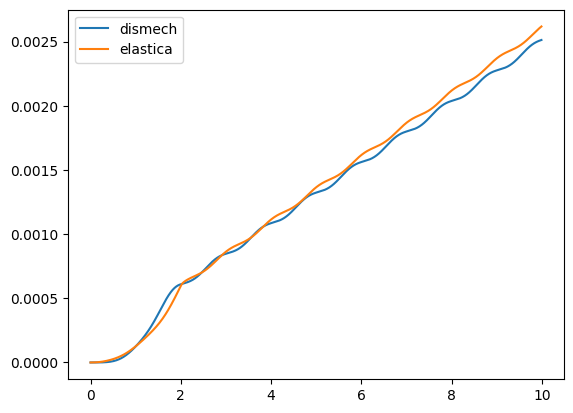

In [ ]:
import matplotlib.pyplot as plt

qs = np.stack([robot.state.q for robot in robots])

# You can use ['t'] from pyelastica
plt.plot(pye_snake['t'], qs[:, 0], label="dismech")
plt.plot(pye_snake['t'], pye_snake['p'], label="elastica")
plt.legend()
plt.show()

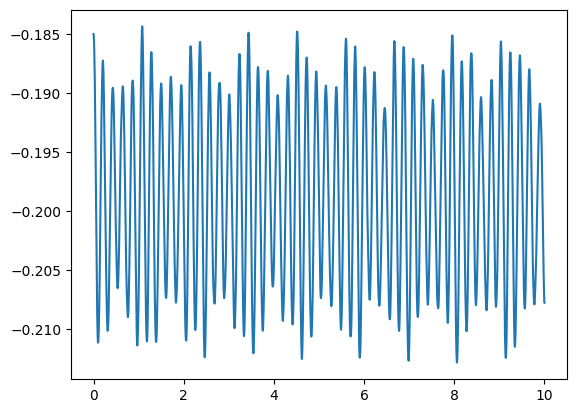

In [ ]:
plt.plot(pye_helix_1e7['t'], pye_helix_1e7['p'])
plt.show()

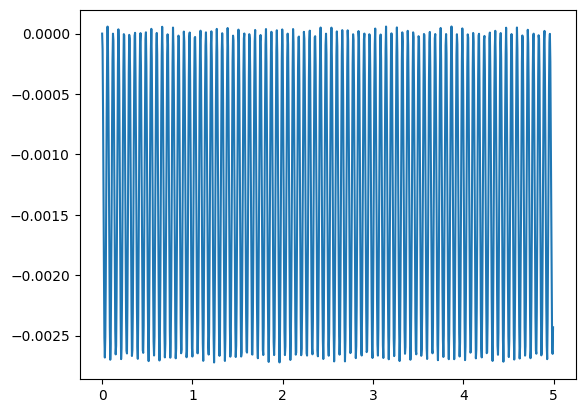

In [ ]:
plt.plot(pye_cantilever['t'], pye_cantilever['p'])
plt.show()